In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
from penny_to_graph_31 import Penny_to_Graph
from graph_utils_1 import *
from quantum_circuit_optimization_13 import *

In [3]:
[ds] = qml.data.load("ketgpt")

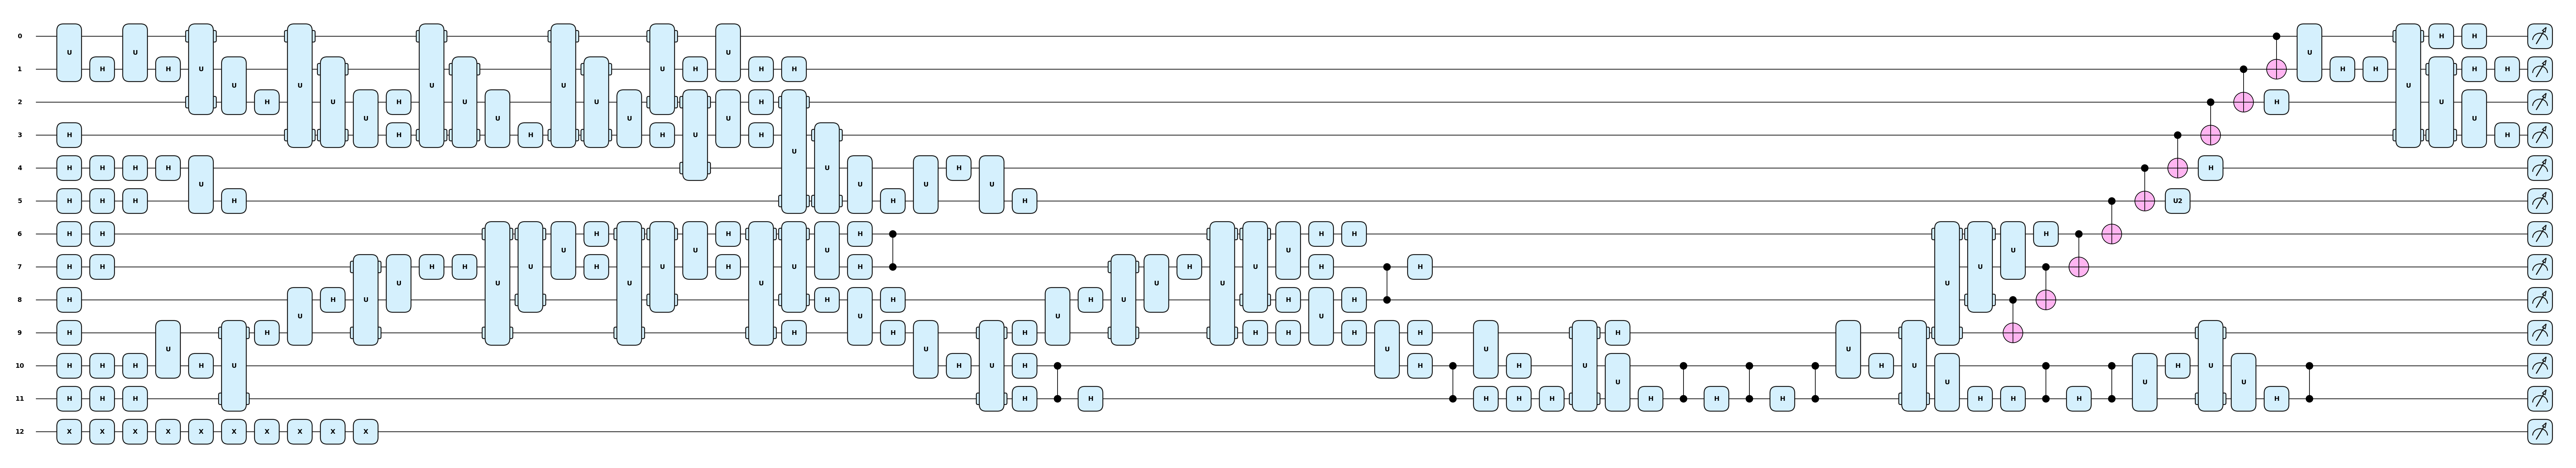

               0
num_qubit     13
num_gate     187
num_1q_gate  104
num_2q_gate   19
unitary       64
depth         65
None


In [4]:
seed = 0

@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for op in ds.circuits[seed]:
        qml.apply(op)
    return qml.state()

fig, axs = qml.draw_mpl(circuit, style='pennylane')()
plt.show()

print(summary_penny(circuit))

               0
num_qubit     12
num_gate     143
num_1q_gate   60
num_2q_gate   19
unitary       64
depth         59
None


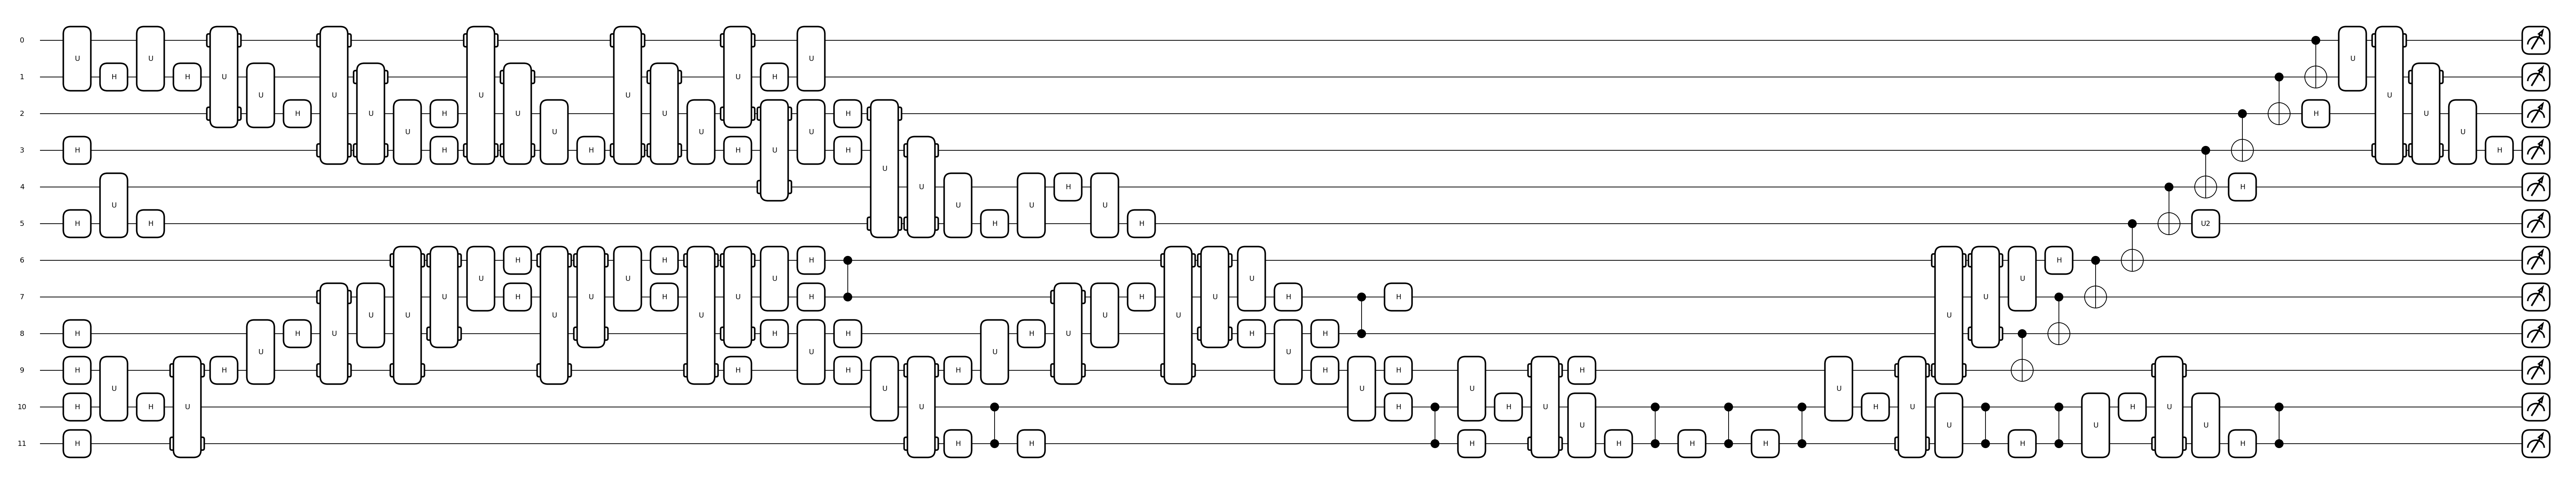

In [5]:
qnode_q1 = optimization_level_1(circuit)

               0
num_qubit     12
num_gate     143
num_1q_gate   60
num_2q_gate   19
unitary       64
depth         59
None


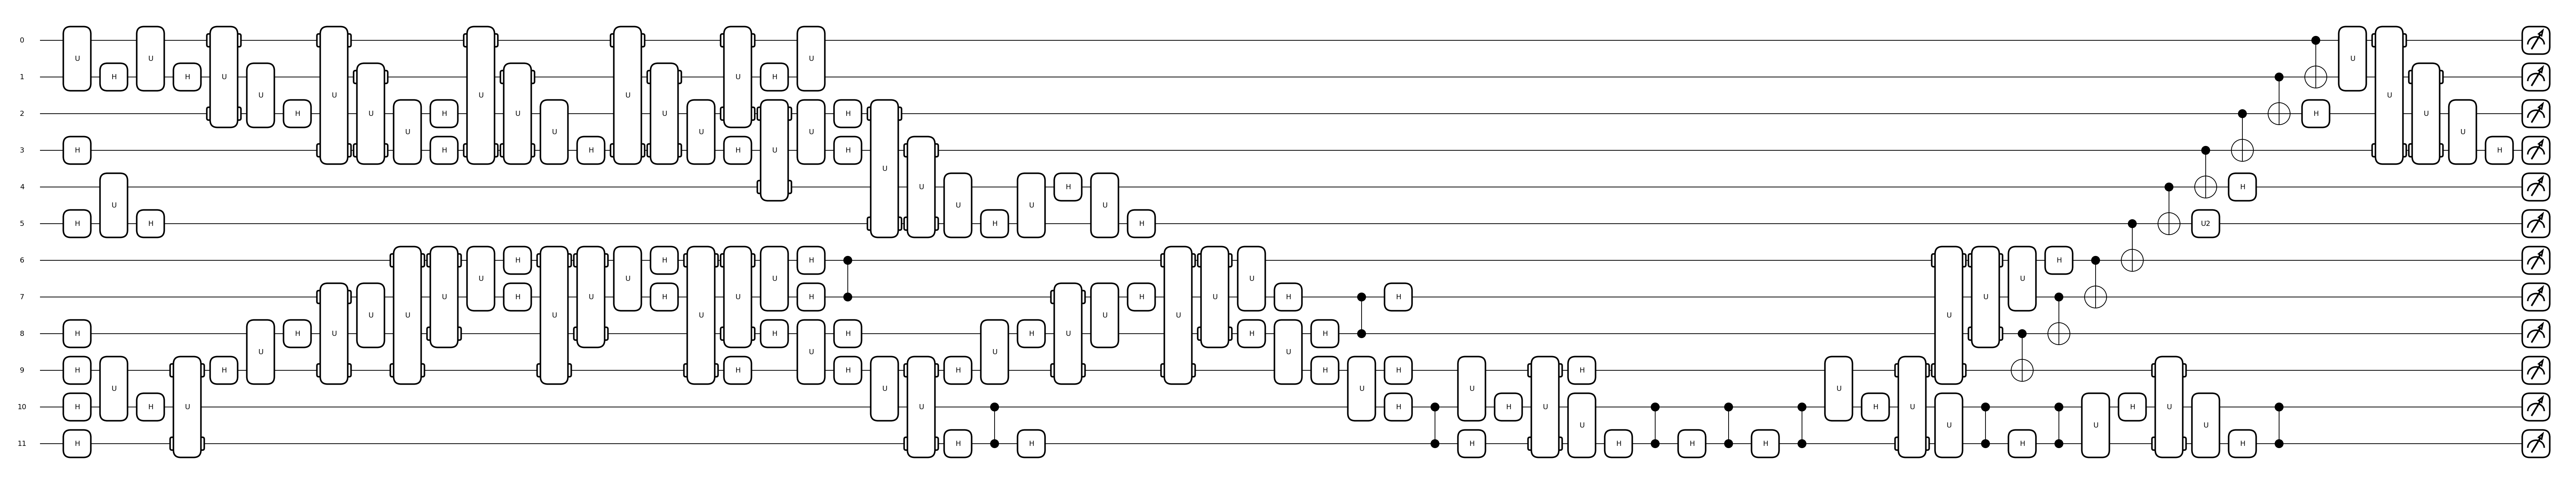

In [6]:
qnode_q2 = optimization_level_2(qnode_q1)

In [302]:
pg = Penny_to_Graph(qnode_q2)
G = pg.G
circuit_info = extract_info_from_qnode(qnode_q2)

barriers = [node for node in G.nodes if any(gate in node for gate in ['QubitUnitary'])]
barrier_set = set(barriers) # unitaries

G_sub = G.subgraph([node for node in G.nodes if node not in barrier_set])

subgraphs = []

G_directed = G_sub
G_undirected = G_directed.to_undirected()
gate_2q = [n for n, attr in G_undirected.nodes(data=True) if attr.get('num_q') == 2]

for center in gate_2q:
    reference_wires = set(get_wire(G_undirected, center))
    visited = set()
    stack = [center]
    valid_nodes = set()

    while stack:
        current = stack.pop()
        if current in visited:
            continue
        visited.add(current)

        current_wires = set(get_wire(G_undirected, current))
        if not current_wires.issubset(reference_wires):
            continue

        valid_nodes.add(current)

        # Predecessors
        for pred in G_directed.predecessors(current):
            if pred in visited:
                continue

            pred_wires = set(get_wire(G_undirected, pred))
            if not pred_wires.issubset(reference_wires):
                continue

            if G_directed.nodes[pred].get('num_q') == 2:
                succ = between_nodes(G_directed, pred, current)
                if len(succ) == 0:
                    continue
                succ_wires = []
                for s in succ:
                    succ_wires.extend(get_wire(G_undirected, s))
                if not set(succ_wires).issubset(reference_wires):
                    continue

            stack.append(pred)

        # Successors
        for succ in G_directed.successors(current):
            if succ in visited:
                continue

            succ_wires = set(get_wire(G_undirected, succ))
            if not succ_wires.issubset(reference_wires):
                continue

            if G_directed.nodes[succ].get('num_q') == 2:
                preds = between_nodes(G_directed, current, succ)
                if len(preds) == 0:
                    continue
                preds_wires = []
                for p in preds:
                    preds_wires.extend(get_wire(G_undirected, p))
                if not set(preds_wires).issubset(reference_wires):
                    continue

            stack.append(succ)

    if len(valid_nodes) > 1:
        subG = G_undirected.subgraph(valid_nodes).copy()
        subgraphs.append({'center': center, 'wires': list(reference_wires), 'subG': subG})

unique_subgraphs = get_unique_subgraphs(subgraphs)
communities = []
for elem in unique_subgraphs:
    communities.append(set(elem['nodes']))

barriers = [n for n in list(G.nodes()) if n not in set().union(*communities)]
# barriers as singleton communities
for barrier in barriers:
    communities.append({barrier})

=== done with community indexing

143


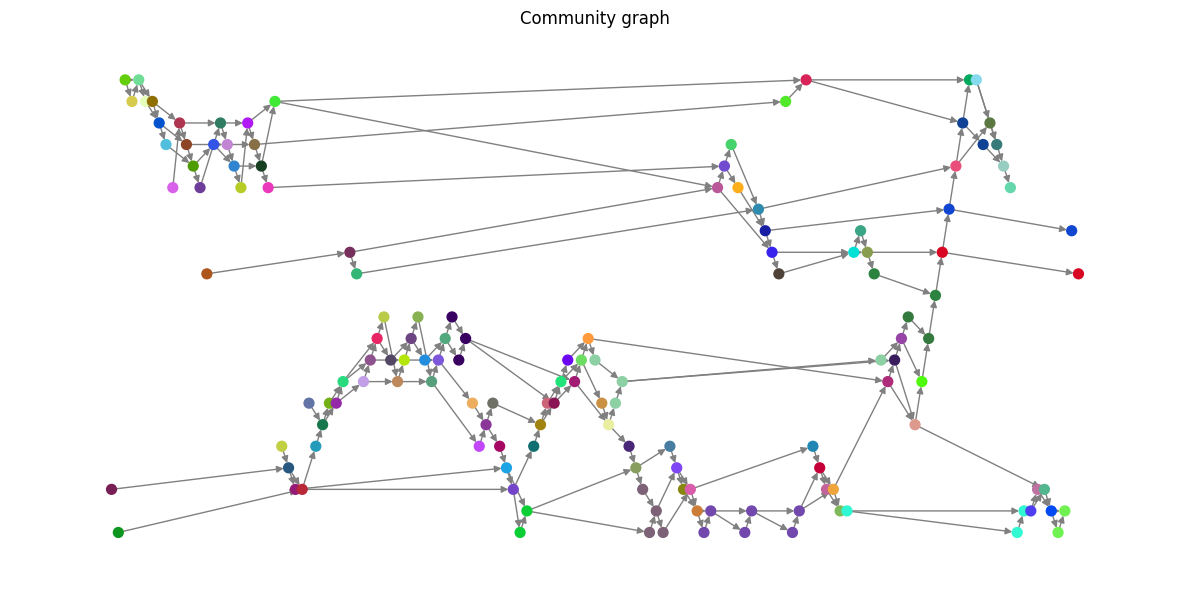

In [303]:
# rearange community indices 
node_to_original_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_original_community[node] = i

community_graph_w_label(G, pg.pos, communities)

In [304]:
def community_sort_test(G, communities, barriers):
    # Step 1: Combine original communities with barrier singletons
    all_communities = communities + [{barrier} for barrier in barriers]

    # Step 2: Map each node to its original community index
    node_to_original = {}
    for i, community in enumerate(all_communities):
        for node in community:
            node_to_original[node] = i

    # Step 3: Reindex communities based on sorted node order
    sorted_nodes = sorted(G.nodes(), key=extract_index)
    original_to_new = {}
    node_to_new = {}
    new_index = 0

    for node in sorted_nodes:
        original = node_to_original[node]
        if original not in original_to_new:
            original_to_new[original] = new_index
            new_index += 1
        node_to_new[node] = original_to_new[original]

    # Step 4: Update node attributes
    for node in G.nodes:
        G.nodes[node]['community'] = node_to_new[node]

    # Step 5: Rebuild sorted communities
    sorted_communities = [set() for _ in range(new_index)]
    for node, idx in node_to_new.items():
        sorted_communities[idx].add(node)

    return G, sorted_communities

143


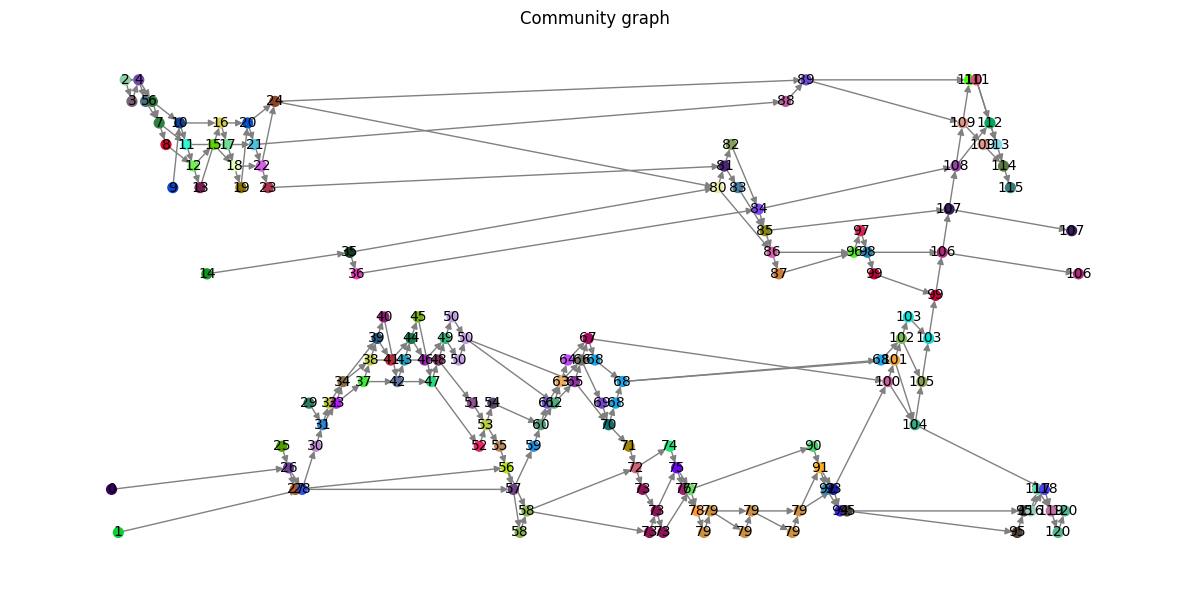

121

In [305]:
# sort the community index with the previous method
G, communities = community_sort_test(G, communities, barriers)
community_graph_w_label(G, pg.pos, communities)
len(communities)

In [306]:
def community_topological_sort_test(G, communities):
    # Step 1: Map each node to its original community index
    node_to_community = {}
    for idx, community in enumerate(communities):
        for node in community:
            node_to_community[node] = idx

    # Step 2: Build meta-graph of community dependencies
    meta_graph = nx.DiGraph()
    meta_graph.add_nodes_from(range(len(communities)))

    for u, v in G.edges():
        cu = node_to_community.get(u)
        cv = node_to_community.get(v)
        if cu is not None and cv is not None and cu != cv:
            meta_graph.add_edge(cu, cv)

    # Step 3: Topological sort of communities
    try:
        sorted_indices = list(nx.topological_sort(meta_graph))
    except nx.NetworkXUnfeasible:
        raise ValueError("Community dependencies contain cycles — cannot sort.")

    # Step 4: Rebuild sorted communities and assign new indices
    sorted_communities = [set() for _ in sorted_indices]
    for new_idx, old_idx in enumerate(sorted_indices):
        for node in communities[old_idx]:
            G.nodes[node]['community'] = new_idx
            sorted_communities[new_idx].add(node)

    return G, sorted_communities

143


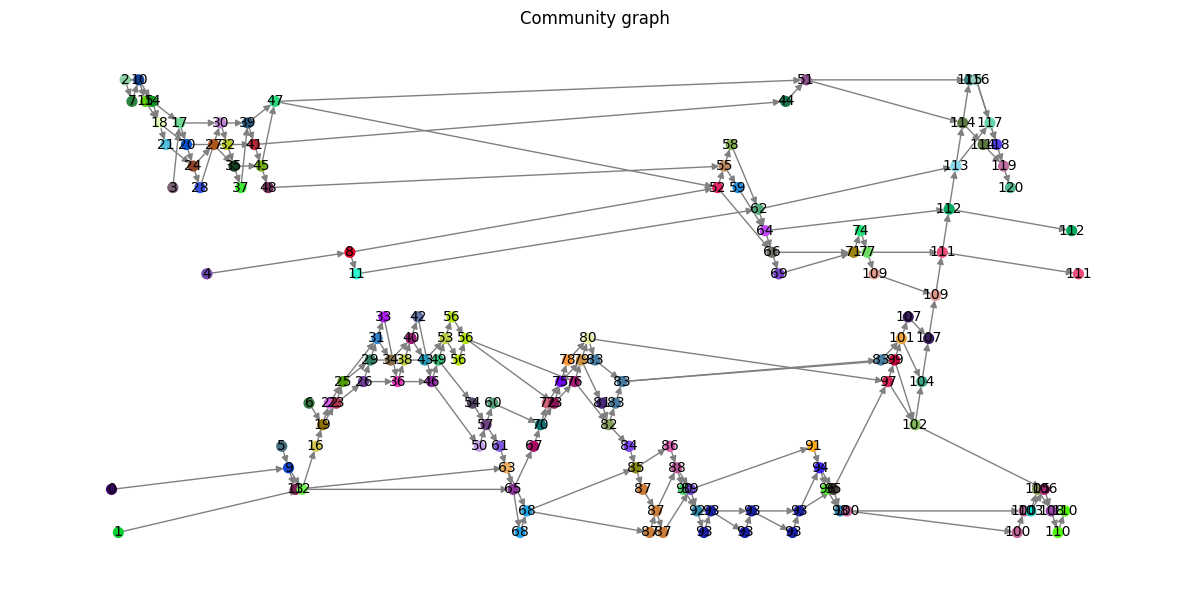

121

In [307]:
G, communities = community_topological_sort_test(G, communities)
community_graph_w_label(G, pg.pos, communities)
len(communities)

               0
num_qubit     12
num_gate     121
num_1q_gate   53
num_2q_gate    4
unitary       64
depth         43
None


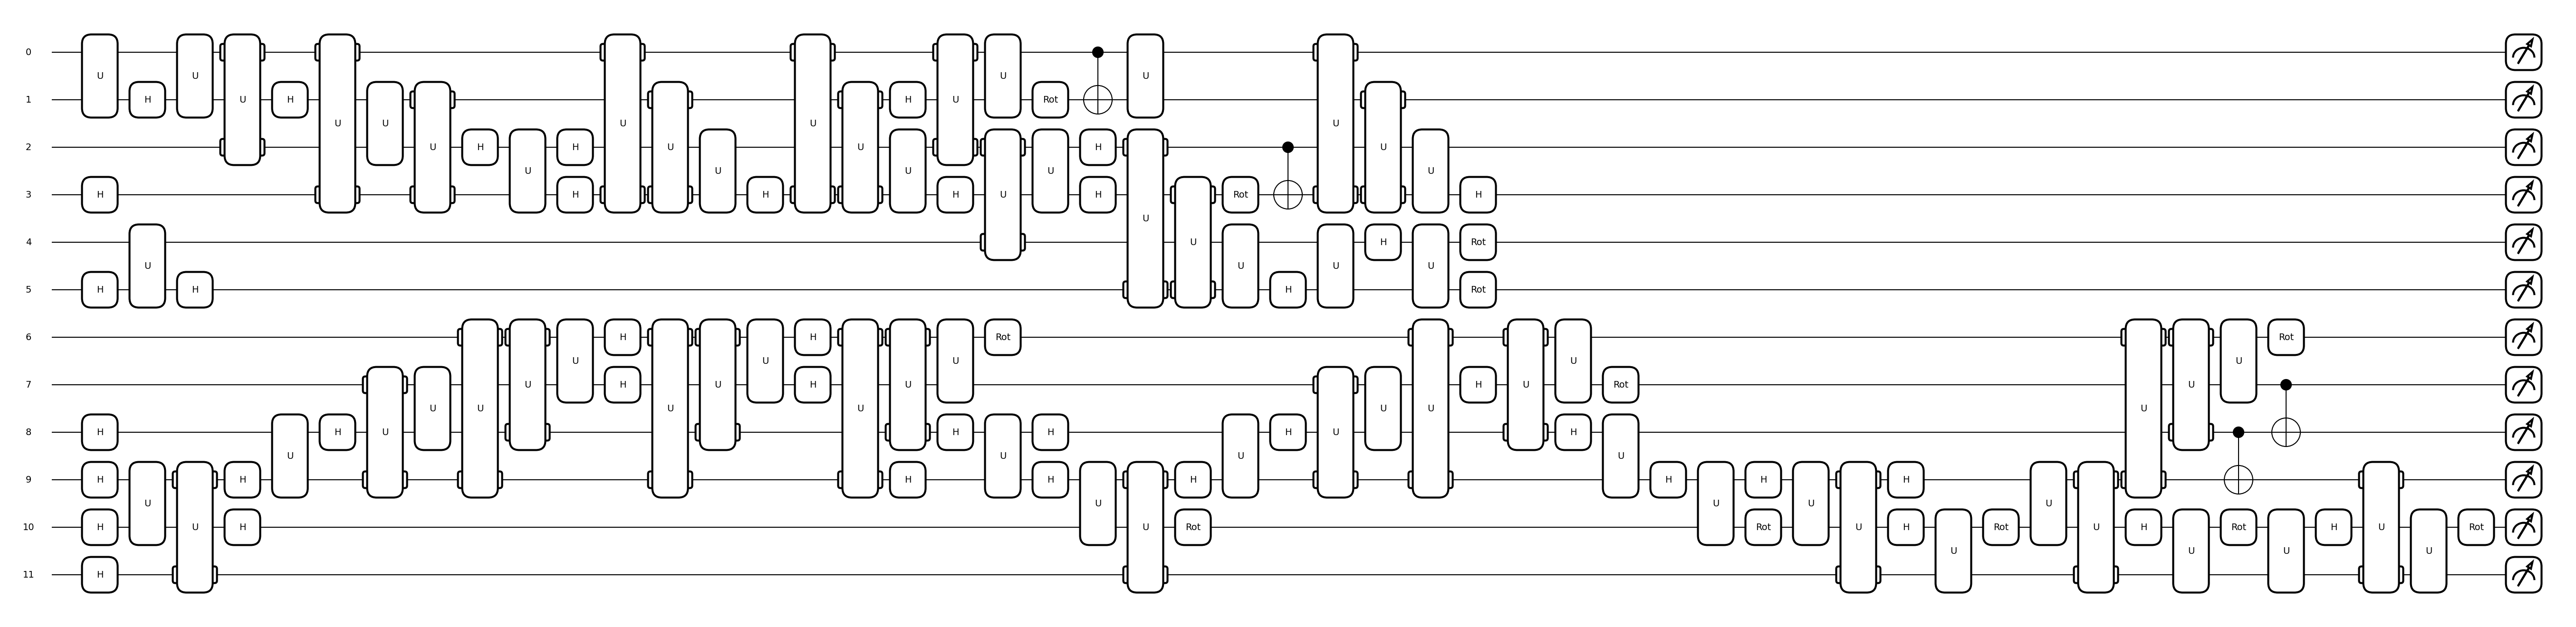

In [290]:
qnode_q3 = subcircuit_syntehsis_level_3_qiskit(G, communities, circuit_info)

# print results
print(summary_penny(qnode_q3))
qml.draw_mpl(qnode_q3)()
plt.show()

In [143]:
from collections import OrderedDict

def dfs(graph, node, visited, result):
    if node in visited:
        return
    visited.add(node)
    result.append(node)
    for neighbor in graph.neighbors(node):
        dfs(graph, neighbor, visited, result)

def multi_root_dfs_complete(graph, root_nodes):
    visited = set()
    result = []

    # Step 1: DFS from each root node
    for root in root_nodes:
        if root in graph.nodes and root not in visited:
            dfs(graph, root, visited, result)

    # Step 2: DFS from any remaining unvisited nodes
    for node in graph.nodes:
        if node not in visited:
            dfs(graph, node, visited, result)
    return result
    
def merge_preserving_primary_order(lists):
    primary = lists[0]
    others = lists[1:]

    # Start with the primary list in order
    seen = OrderedDict((item, None) for item in primary)

    # Add missing elements from other lists in order of appearance
    for lst in others:
        for item in lst:
            if item not in seen:
                seen[item] = None

    return list(seen.keys())

def get_roots(G): # for DiGraph
    return [node for node in G.nodes() if G.in_degree(node) == 0]

def dfs_node_order(G):
    result = []
    roots = get_roots(G)
    for r in roots:
        traversal = multi_root_dfs_complete(G, [r])  # Wrap r in a list
        result.append(traversal)
    path_nodes = merge_preserving_primary_order(result)
    return path_nodes

In [ ]:
def community_sort_dfs(G, communities, barriers, path_nodes):
    # barriers as singleton communities
    for barrier in barriers:
        communities.append({barrier})

    # rearange community indices 
    node_to_original_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node_to_original_community[node] = i

    sorted_nodes = dfs_node_order(G)

    original_to_new_index = {}
    new_index = 0
    node_to_reindexed_community = {}

    for node in sorted_nodes:
        original = node_to_original_community[node]
        if original not in original_to_new_index:
            original_to_new_index[original] = new_index
            new_index += 1
        node_to_reindexed_community[node] = original_to_new_index[original]
    
    # update community attribute
    attribute_name = 'community'
    has_attribute = any(attribute_name in data for _, data in G.nodes(data=True))
    if not has_attribute:
        for node in G.nodes:
            G.nodes[node].pop(attribute_name, None)

    # community index as a node attribute
    for node in G.nodes:
        G.nodes[node]['community'] = node_to_reindexed_community[node]
    return G, communities

In [269]:
def community_graph_w_label(G, pos, communities):
    def color_generator(n):
        random.seed(42)
        colors = []
        for _ in range(n):
            hex_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
            colors.append(hex_color)
        return colors

    palette = color_generator(len(communities))
    node_color_map = {}
    for i, community in enumerate(communities):
        color = palette[i % len(palette)]
        for node in community:
            node_color_map[node] = color

    labels = {node: G.nodes[node].get('community', '') for node in G.nodes()}
    print(len(labels))
    node_colors = [node_color_map.get(node, '#999999') for node in G.nodes]

    # Step 4: Draw the graph
    fig, ax = plt.subplots(figsize=(12, 6))
    nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=50, font_size=8, edge_color='gray', ax=ax)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, ax=ax)

    plt.title('Community graph')
    plt.tight_layout()
    plt.show()

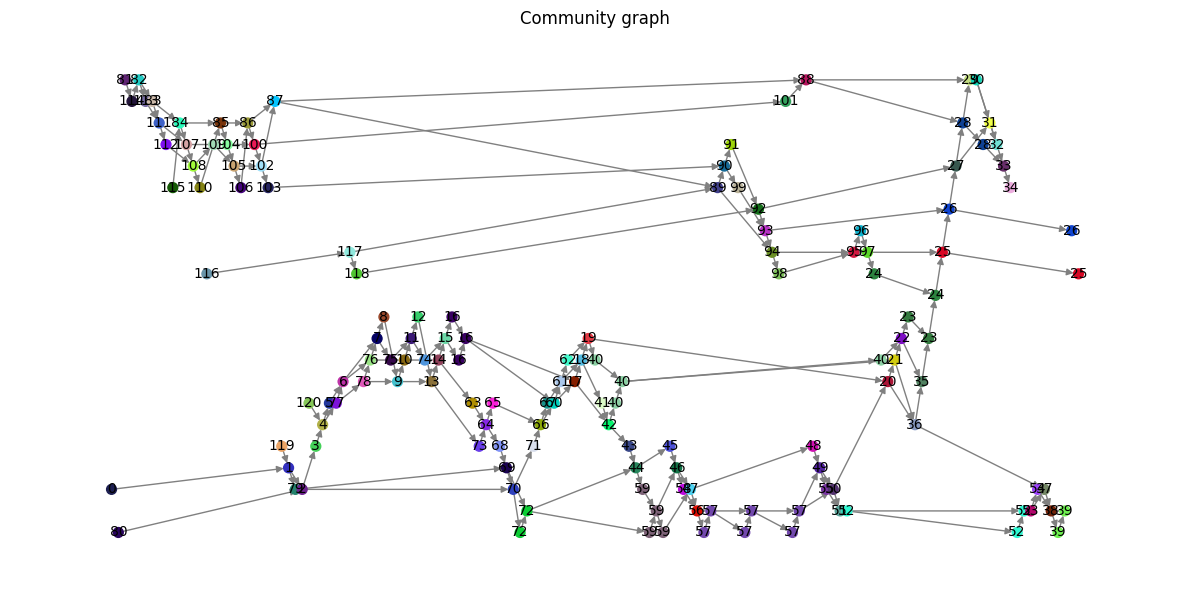

In [148]:
G, communities = community_sort_dfs(G, communities, barriers, dfs_node_order(G))
community_graph_w_label(G, pg.pos, communities)

               0
num_qubit     12
num_gate     143
num_1q_gate   60
num_2q_gate   19
unitary       64
depth         59
None


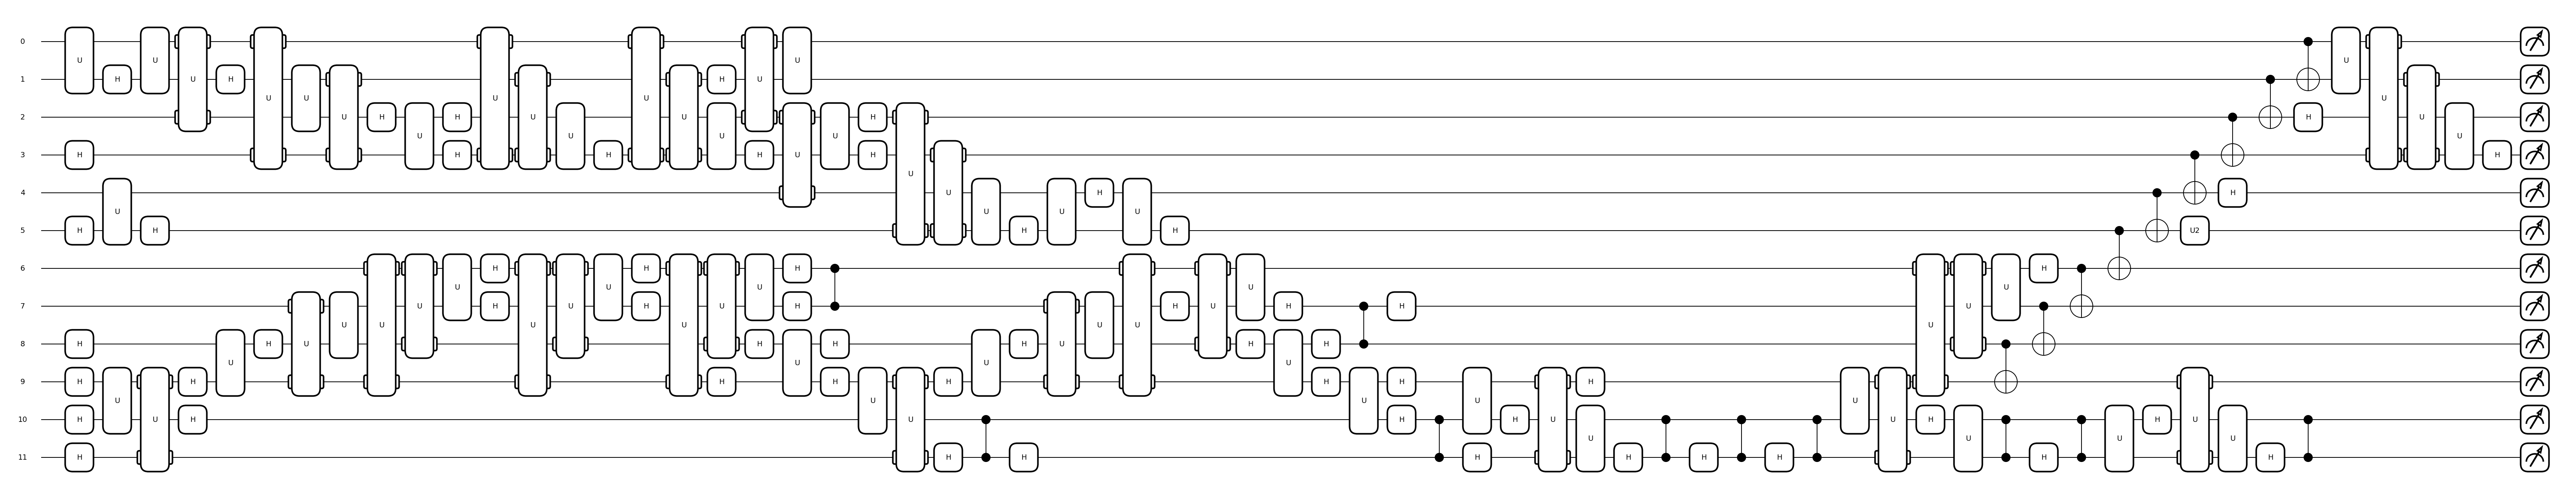

In [160]:
qnode_q3 = subcircuit_syntehsis_level_3_qiskit(G, communities, circuit_info)

# print results
print(summary_penny(qnode_q3))
qml.draw_mpl(qnode_q3)()
plt.show()

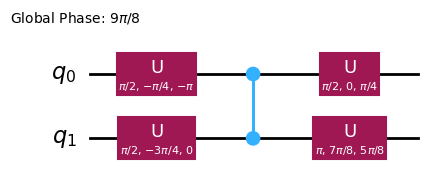

In [8]:
# unitary synthesis 
from qiskit.visualization import circuit_drawer
from qiskit.transpiler.passes.synthesis import UnitarySynthesis
from qiskit.transpiler import PassManager
from qiskit import QuantumCircuit

# qnode to tape to get the matrix
quantum_fn = qnode_q3.func
with qml.tape.QuantumTape() as tape:
    quantum_fn()
u = qml.matrix(tape, wire_order=[0,1])

basis = ['h', 'x', 'cx', 'cz', 'ry', 'u1', 'u2'] 
extended_basis = basis + ['y', 'z', 'swap', 'rx', 'rz']
qc = QuantumCircuit(2)
qc.unitary(u, range(2))
synth_pass = UnitarySynthesis(basis_gates=basis) # basis_gates=basis
pm = PassManager(synth_pass)
optimized_circuit = pm.run(qc)
circuit_drawer(optimized_circuit, output='mpl') 

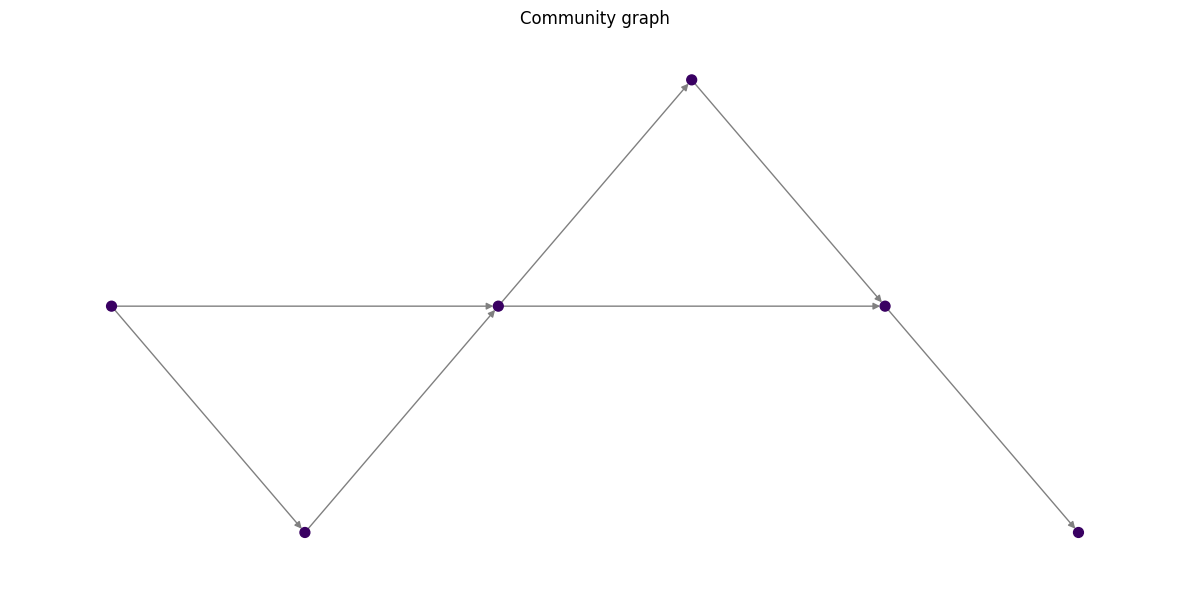

In [267]:
def optimization_prep(qnode):
    pg = Penny_to_Graph(qnode)
    G = pg.G
    circuit_info = extract_info_from_qnode(qnode)
    return G, circuit_info

def graph_alg_level_3(G):
    communities = get_communities(G)
    barriers = [n for n in list(G.nodes()) if n not in set().union(*communities)]
    # print(len(G.nodes), len(barriers))
    return community_sort(G, communities, barriers)

pg = Penny_to_Graph(qnode_q2)
G = pg.G
G, communities = graph_alg_level_3(G)
community_graph(G, pg.pos, communities)

In [268]:
def qiskit_optimization(u):
    basis = ['h', 'x', 'cx', 'cz', 'ry', 'u', 'u1', 'u2'] 
    qc = QuantumCircuit(2)
    qc.unitary(u, range(2))
    synth_pass = UnitarySynthesis(basis_gates=basis) # basis_gates=basis
    pm = PassManager(synth_pass)
    optimized_circuit = pm.run(qc)
    qnoe_temp = qml.from_qiskit(optimized_circuit)
    dev = qml.device("default.qubit", wires=2)
    return extract_info_from_qnode(qml.QNode(qnoe_temp, dev))

def wire_mapping(circuit_info, wires):
    wire_map = {0: wires[0], 1: wires[1]}
    remapped_gates = []
    for gate in circuit_info:
        remapped_gate = gate.copy()
        remapped_gate['wires'] = [wire_map[w] for w in gate['wires']]
        remapped_gates.append(remapped_gate)
    return remapped_gates

def subcircuit_syntehsis_level_3_qiskit(G, communities, circuit_info):
    community_circuit_info = subcircuit_syntehsis_prep(G, communities, circuit_info)

    for idx, ci in enumerate(community_circuit_info):
        if len(ci) > 1:
            matrix, wires = info_to_qnode_matrix(ci)
            community_circuit_info[idx] = wire_mapping(qiskit_optimization(matrix), wires)

    community_circuit_info = [item[0] for item in community_circuit_info if isinstance(item, list) and item and isinstance(item[0], dict)]
    community_circuit_info = [gate for gate in community_circuit_info if gate]

    return community_circuit_info

In [269]:
def info_to_qnode(circuit_info):
    dev = qml.device('default.qubit')
    def circuit():
        for gate in circuit_info:
            name = gate['name']
            wires = gate['wires']
            params = gate['params']
            if name == 'Hadamard':
                qml.Hadamard(wires=wires[0])
            elif name == 'PauliX':
                qml.PauliX(wires=wires[0])
            elif name == 'U2':
                qml.U2(params[0], params[1], wires=wires[0])
            elif name == 'CNOT':
                qml.CNOT(wires=wires)            
            elif name == 'CZ':
                qml.CZ(wires=wires)
            elif name == 'QubitUnitary':
                matrix = np.array(params[0])
                qml.QubitUnitary(matrix, wires=wires)
            elif name == 'U3':
                qml.Rot(params[0], params[1], params[2], wires=wires)
            else:
                raise ValueError(f"Unsupported gate: {name}")
        return qml.state()
    qnode = qml.QNode(circuit, dev)
    return qnode

             0
num_qubit    1
num_gate     1
num_1q_gate  1
num_2q_gate  0
unitary      0
depth        1
None


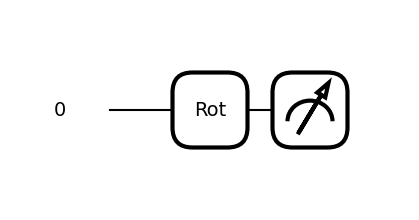

In [270]:
circuit_info = extract_info_from_qnode(qnode_q2)
community_circuit_info = subcircuit_syntehsis_level_3_qiskit(G, communities, circuit_info)
qnode_q3 = info_to_qnode(community_circuit_info)
# print results
print(summary_penny(qnode_q3))
qml.draw_mpl(qnode_q3)()
plt.show()

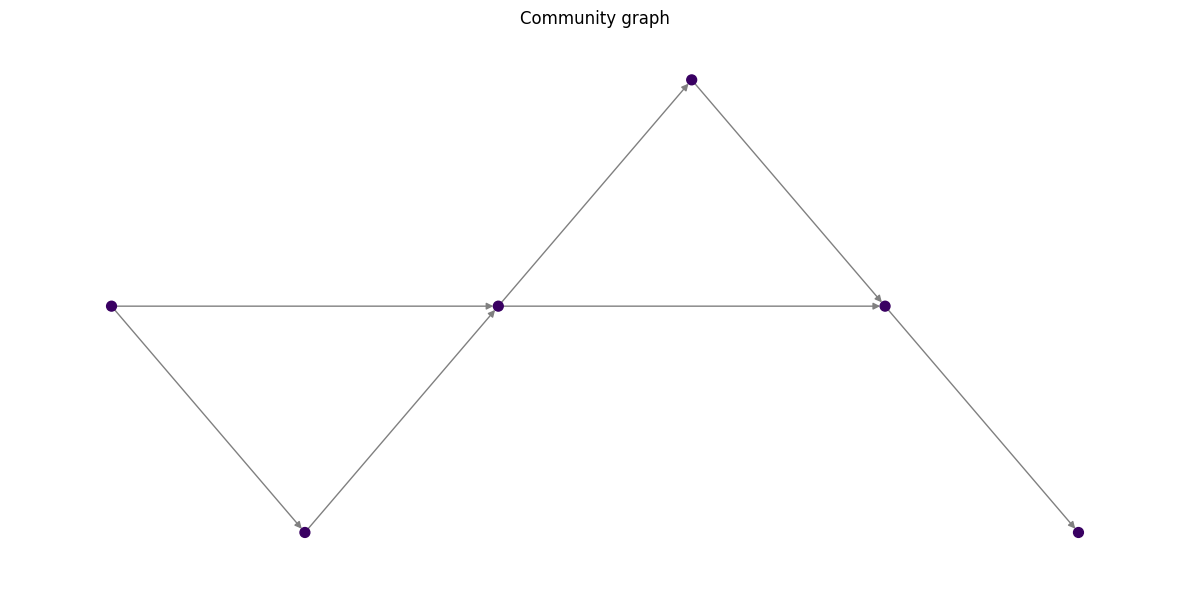

In [188]:
pg = Penny_to_Graph(qnode_q2)
G = pg.G   
circuit_info = extract_info_from_qnode(qnode_q2)
G, communities = graph_alg_level_3(G, barriers=['QubitUnitary'])
community_graph(G, pg.pos, communities)

In [189]:
community_circuit_info = subcircuit_syntehsis_prep(G, communities, circuit_info)
community_circuit_info

[[{'name': 'CZ', 'wires': [0, 1], 'params': []},
  {'name': 'Hadamard', 'wires': [1], 'params': []},
  {'name': 'CNOT', 'wires': [0, 1], 'params': []},
  {'name': 'Hadamard', 'wires': [0], 'params': []},
  {'name': 'CZ', 'wires': [1, 0], 'params': []},
  {'name': 'Hadamard', 'wires': [1], 'params': []}]]

In [256]:
# qiskit
from qiskit.visualization import circuit_drawer
from qiskit.transpiler.passes.synthesis import UnitarySynthesis
from qiskit.transpiler import PassManager
from qiskit import QuantumCircuit

# qnode to tape to get the matrix
quantum_fn = qnode_q2.func
with qml.tape.QuantumTape() as tape:
    quantum_fn()
u = qml.matrix(tape, wire_order=[0,1])

basis = ['h', 'x', 'cx', 'cz', 'ry', 'u1', 'u2'] 
extended_basis = basis + ['y', 'z', 'swap', 'rx', 'rz']
qc = QuantumCircuit(2)
qc.unitary(u, range(2))
synth_pass = UnitarySynthesis(basis_gates=extended_basis) # basis_gates=basis
pm = PassManager(synth_pass)
optimized_circuit = pm.run(qc)
circuit_drawer(optimized_circuit, output='mpl') 

TransformError: Wires in circuit [10, 11, 1, 0, 2, 3, 5, 9, 8, 7, 4, 6] are inconsistent with those in wire_order [0, 1]

In [225]:
pl_fn = qml.from_qiskit(optimized_circuit)
dev = qml.device("default.qubit", wires=2)
test = qml.QNode(pl_fn, dev)
extract_info_from_qnode(test)

[{'name': 'U3',
  'wires': [0],
  'params': [1.5707963267948968, -0.7853981633974492, -3.141592653589793]},
 {'name': 'U3',
  'wires': [1],
  'params': [1.5707963267948966, -2.356194490192345, 0.0]},
 {'name': 'CZ', 'wires': [0, 1], 'params': []},
 {'name': 'U3',
  'wires': [0],
  'params': [1.5707963267948966, 0.0, 0.7853981633974483]},
 {'name': 'U3',
  'wires': [1],
  'params': [3.141592653589793, 2.7488935718910685, 1.9634954084936211]}]

In [227]:
def wire_mapping(circuit_info, wires):
    wire_map = {0: wires[0], 1: wires[1]}
    remapped_gates = []
    for gate in circuit_info:
        remapped_gate = gate.copy()
        remapped_gate['wires'] = [wire_map[w] for w in gate['wires']]
        remapped_gates.append(remapped_gate)
    return remapped_gates

In [228]:
wire_mapping(extract_info_from_qnode(test), [5,6])

[{'name': 'U3',
  'wires': [5],
  'params': [1.5707963267948968, -0.7853981633974492, -3.141592653589793]},
 {'name': 'U3',
  'wires': [6],
  'params': [1.5707963267948966, -2.356194490192345, 0.0]},
 {'name': 'CZ', 'wires': [5, 6], 'params': []},
 {'name': 'U3',
  'wires': [5],
  'params': [1.5707963267948966, 0.0, 0.7853981633974483]},
 {'name': 'U3',
  'wires': [6],
  'params': [3.141592653589793, 2.7488935718910685, 1.9634954084936211]}]

In [226]:
# u3?
optimized = transpile(optimized_circuit, basis_gates=['u1', 'u2', 'cx'])
print(optimized)

global phase: 15π/8
     ┌────────┐┌──────────┐┌─────────┐┌──────────┐┌──────────┐┌──────────┐»
q_0: ┤ U1(-π) ├┤ U1(-π/2) ├┤ U2(0,π) ├┤ U1(-π/2) ├┤ U1(3π/2) ├┤ U1(-π/2) ├»
     ├───────┬┘├──────────┤├─────────┤├──────────┤├──────────┤├──────────┤»
q_1: ┤ U1(0) ├─┤ U1(-π/2) ├┤ U2(0,π) ├┤ U1(-π/2) ├┤ U1(3π/2) ├┤ U1(-π/2) ├»
     └───────┘ └──────────┘└─────────┘└──────────┘└──────────┘└──────────┘»
«     ┌─────────┐┌──────────┐┌───────────┐                ┌─────────┐»
«q_0: ┤ U2(0,π) ├┤ U1(-π/2) ├┤ U1(11π/4) ├─────────────■──┤ U1(π/4) ├»
«     ├─────────┤├──────────┤└┬──────────┤┌─────────┐┌─┴─┐├─────────┤»
«q_1: ┤ U2(0,π) ├┤ U1(-π/2) ├─┤ U1(9π/4) ├┤ U2(0,π) ├┤ X ├┤ U2(0,π) ├»
«     └─────────┘└──────────┘ └──────────┘└─────────┘└───┘└─────────┘»
«     ┌──────────┐┌─────────┐ ┌──────────┐┌──────────┐┌──────────┐┌─────────┐ »
«q_0: ┤ U1(-π/2) ├┤ U2(0,π) ├─┤ U1(-π/2) ├┤ U1(3π/2) ├┤ U1(-π/2) ├┤ U2(0,π) ├─»
«     ├──────────┤├─────────┴┐├─────────┬┘├──────────┤└┬────────┬┘├─────────┴┐»
«q_1:

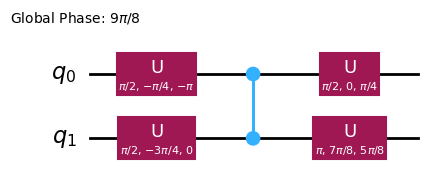

In [214]:
transpiled_circuit = transpile(qc, basis_gates=extended_basis)
circuit_drawer(transpiled_circuit, output='mpl')  

In [191]:
def all_gate_combinations(community_circuit_info_component):
    gate_combs = []
    n = len(community_circuit_info_component)
    for start in range(n):
        for end in range(start + 2, n + 1):  # end index is exclusive
            gate_combs.append(community_circuit_info_component[start:end])
    return gate_combs

all_gate_combinations(community_circuit_info[0])

[[{'name': 'CZ', 'wires': [0, 1], 'params': []},
  {'name': 'Hadamard', 'wires': [1], 'params': []}],
 [{'name': 'CZ', 'wires': [0, 1], 'params': []},
  {'name': 'Hadamard', 'wires': [1], 'params': []},
  {'name': 'CNOT', 'wires': [0, 1], 'params': []}],
 [{'name': 'CZ', 'wires': [0, 1], 'params': []},
  {'name': 'Hadamard', 'wires': [1], 'params': []},
  {'name': 'CNOT', 'wires': [0, 1], 'params': []},
  {'name': 'Hadamard', 'wires': [0], 'params': []}],
 [{'name': 'CZ', 'wires': [0, 1], 'params': []},
  {'name': 'Hadamard', 'wires': [1], 'params': []},
  {'name': 'CNOT', 'wires': [0, 1], 'params': []},
  {'name': 'Hadamard', 'wires': [0], 'params': []},
  {'name': 'CZ', 'wires': [1, 0], 'params': []}],
 [{'name': 'CZ', 'wires': [0, 1], 'params': []},
  {'name': 'Hadamard', 'wires': [1], 'params': []},
  {'name': 'CNOT', 'wires': [0, 1], 'params': []},
  {'name': 'Hadamard', 'wires': [0], 'params': []},
  {'name': 'CZ', 'wires': [1, 0], 'params': []},
  {'name': 'Hadamard', 'wires': [

In [ ]:
for idx1, ci in enumerate(community_circuit_info):
    gate_combs = all_gate_combinations(ci)

    for idx2, ci2 in gate_combs:
        matrix, wires = info_to_qnode_matrix(ci2)
        # gate determination
        gate_name = determine_2q_gate_test(matrix)
        if gate_name: 
            print('found')
            community_circuit_info[idx2] = gate_info_array(gate_name, wires)
        else: # no improvement
            print('False')

    if len(ci) > 1:
        matrix, wries = info_to_qnode_matrix(ci)
        # leverage
        community_circuit_info[idx1] =  [{'name': 'QubitUnitary', 'wires': wries, 'params':[matrix]}] # replaced

community_circuit_info = np.array(community_circuit_info).flatten()
community_circuit_info = [gate for gate in community_circuit_info if gate]



TypeError: string indices must be integers

In [ ]:
# chances of being reduced
test = gate_combinations(community_circuit_info[0])
for idx, ci in enumerate(community_circuit_info):
    if len(ci) > 1:
        matrix, wires = info_to_qnode_matrix(ci)
        # single-gate determination
        gate_name = determine_2q_gate_test(matrix)
        if gate_name:
            print('found')
            # community_circuit_info[idx] = gate_info_array(gate_name, wires)
        else: # no improvement
            False

             0
num_qubit    2
num_gate     1
num_1q_gate  0
num_2q_gate  0
unitary      1
depth        1
None


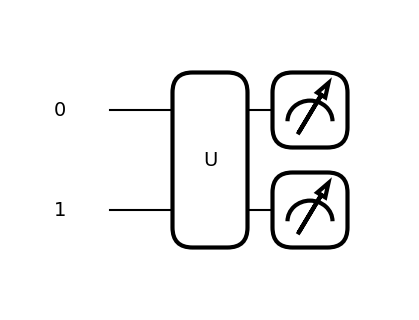

In [136]:
circuit_info = extract_info_from_qnode(qnode_q2)
qnode_q3 = selective_subcircuit_syntehsis(G, communities, circuit_info)

# print results
print(summary_penny(qnode_q3))
qml.draw_mpl(qnode_q3)()
plt.show()